<a href="https://colab.research.google.com/github/mvs22/Criatividade/blob/main/git_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import and configure modules

In [2]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
%matplotlib inline

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [6]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [7]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [11]:
!git clone https://github.com/mvs22/Criatividade

Cloning into 'Criatividade'...
remote: Enumerating objects: 776, done.
remote: Counting objects: 100% (776/776), done.
remote: Compressing objects: 100% (765/765), done.
remote: Total 776 (delta 6), reused 761 (delta 2), pack-reused 0
Receiving objects: 100% (776/776), 373.14 MiB | 13.88 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (697/697), done.


In [9]:
caminho_autores = 'Criatividade/imagens/autores/'
caminho_pinturas = 'Criatividade/imagens/pinturas/'
caminho_resultado = 'Criatividade/imagens/results/'
lista_autores = []

In [10]:
if len(lista_autores) == 0:
  lista_autores = os.listdir(caminho_autores)
lista_autores

FileNotFoundError: ignored

  ## Fast Style Transfer using TF-Hub

This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. Before getting into the details, let's see how the [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) does this:

In [18]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

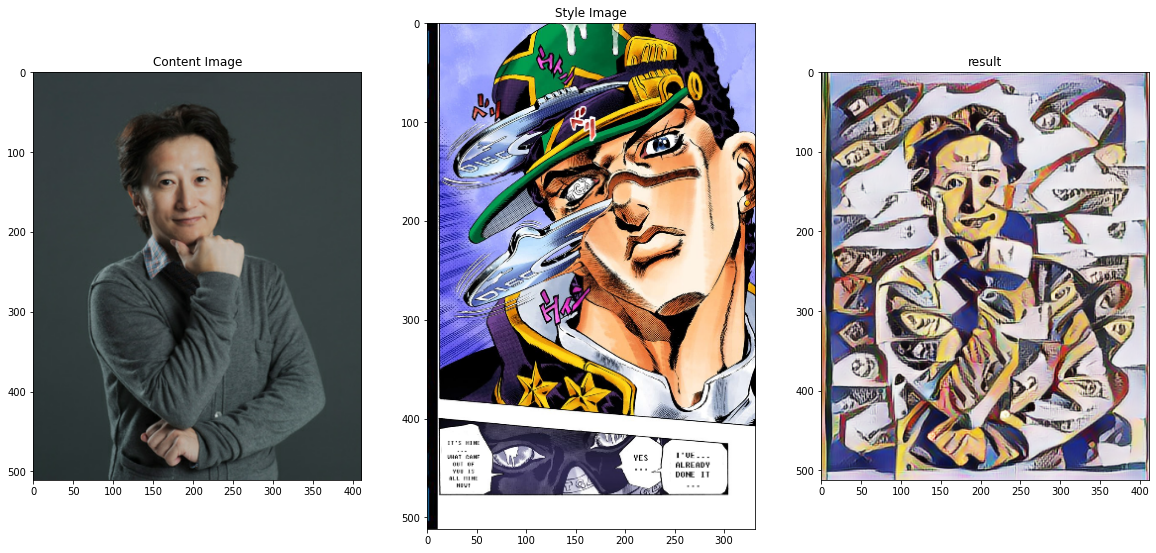

In [19]:
#os.mkdir(caminho_resultado)
for obra in lista_autores:
  #num_image_autor = len(os.listdir(caminho_autores + obra))
  #num_image_style = len(os.listdir(caminho_pinturas + obra))
  #num_images_result = num_image_autor * num_image_style
  num = 0
  #os.mkdir(f"{caminho_resultado + obra}")
  for imagem_autor in os.listdir(caminho_autores + obra):
    content_image = load_img(caminho_autores + obra + f'/{imagem_autor}')
    for imagem_arte in os.listdir(caminho_pinturas + obra):
      style_image = load_img(caminho_pinturas + obra + f'/{imagem_arte}')
      fig = plt.figure(figsize=(20,20))

      plt.subplot(1, 3, 1)
      imshow(content_image, 'Content Image')

      plt.subplot(1, 3, 2)
      imshow(style_image, 'Style Image')

      stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
      tensor_to_image(stylized_image)
      
      plt.subplot(1, 3, 3)
      imshow(stylized_image,'result')
      
      num += 1
      fig.savefig(caminho_resultado + obra + f'/{imagem_autor.split(".")[0]}_{num}.png')

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Transferindo arquivos de pasta local para drive
#OBS: Quando voce for rodar, verifique esse path resultante
!cp -av '/content/Criatividade/imagens/results' '/content/drive/MyDrive/resultados_criatividade'

# Testando com outros modelos de classificação de imagens como o VGG19

In [15]:
#carregando modelo
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
#definindo as camadas que vamos usar do modelo VGG para extrair o conteudo da imagem de conteudo
#e o estilo da imagem de estilo
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                    for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                        for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                          for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers
  loss = style_loss + content_loss
  return loss

def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))


80150528/80134624 [==============================] - 0s 0us/step


Vamos rodar um finetunning das camadas intermediarias do VGG em cima do nosso dataset:

In [ ]:
for obra in lista_autores: #interando entre os autores
  
  num = 0

  for imagem_autor in os.listdir(caminho_autores + obra): #interando entre as fotos dos autores
    content_image = load_img(caminho_autores + obra + f'/{imagem_autor}')
    for imagem_arte in os.listdir(caminho_pinturas + obra): #interando entre as obras de arte do autor

      style_image = load_img(caminho_pinturas + obra + f'/{imagem_arte}')
      fig = plt.figure(figsize=(20,20))

      plt.subplot(1, 3, 1)
      imshow(content_image, 'Content Image')

      plt.subplot(1, 3, 2)
      imshow(style_image, 'Style Image')

      #criando as camadas para extrair o conteudo e o estilo
      style_extractor = vgg_layers(style_layers) 
      style_outputs = style_extractor(style_image*255)

      
      extractor = StyleContentModel(style_layers, content_layers)

      results = extractor(tf.constant(content_image))
      
      style_targets = extractor(style_image)['style']
      content_targets = extractor(content_image)['content']

      image = tf.Variable(content_image)

      
      
      opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

      style_weight=1e-2
      content_weight=1e4
      

      epochs = 10
      steps_per_epoch = 100

      #fine tunning de alguns ciclos para melhorar o resultado do style transfer
      step = 0
      for n in range(epochs):
        for m in range(steps_per_epoch):
          step += 1
          train_step(image)
        
        print("Train step: {}".format(step))


      
      plt.subplot(1, 3, 3)
      imshow(image,'result')
      num += 1
      fig.savefig(caminho_resultado + obra + f'/{imagem_autor.split(".")[0]}_{num}.png')